In [1]:
%matplotlib inline
import random
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [2]:
sys.version

'2.7.15 (default, Nov 16 2018, 23:13:11) \n[GCC 6.3.0 20170516]'

### Read and preprocess data files

In [3]:
df_all = pd.read_csv('./data/data_all.csv')
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

df_test = pd.read_csv('./data/data_test.csv')

In [4]:
categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)

In [5]:
df_features = df_all_categorical
df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)
print(df_features.columns)

Index([u'Composition_Cannot tell', u'Composition_Cystic',
       u'Composition_Entirely or almost entirely solid',
       u'Composition_Mixed cystic_solid', u'Composition_Spongiform',
       u'Echogenicity_Cant classify', u'Echogenicity_Hyper',
       u'Echogenicity_Iso', u'Echogenicity_Mild Hypo',
       u'Echogenicity_Very Hypo', u'Shape_n', u'Shape_y',
       u'MargA_Cant classify', u'MargA_Ill-defined', u'MargA_Lobulated',
       u'MargA_Well-defined', u'Calcs_None', u'Calcs_Peripheral_eggshell',
       u'Calcs_Colloid', u'Calcs_Macro', u'Calcs_PEF'],
      dtype='object')


### Remove test cases

In [6]:
df_features['ID'] = df_all['ID']
test_ids = df_test['ID'].as_matrix()
df_features = df_features[~df_features.ID.isin(test_ids)]
df_features.drop(columns=['ID'], inplace=True)
df_train = df_all[~df_all.ID.isin(test_ids)]

y_true_train = df_train.Cancer

### ROC AUC loss function

In [7]:
def tirads_auc_loss(w):
    # Add 0 points for cystic and spongiform features which are not optimized
    w = np.array([w[:1] + [0] + w[1:3] + [0] + w[3:]])
    
    X = df_features.as_matrix()
    
    # Give 0 total points for all cystic and spongiform nodules
    x_cyst = X[:, 1]
    x_cyst = np.abs(x_cyst - 1)
    x_spon = X[:, 4]
    x_spon = np.abs(x_spon - 1)
    
    X = X * np.expand_dims(x_cyst, axis=-1)
    X = X * np.expand_dims(x_spon, axis=-1)
    
    # Compute AI TI-RADS points
    ai_tirads_points = np.dot(X, w.T).flatten()
    
    return roc_auc_score(y_true_train, ai_tirads_points),

### Optimization with genetic algorithm

In [8]:
# Number of indiviguals in population
population_count = 100

# Maximize loss function (ROC AUC)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def initIndividual(icls, content):
    return icls(content)

# All individuals in initial population are ACR TI-RADS
def initPopulation(pcls, ind_init, initial_state):
    return [pcls(ind_init(eval(initial_state)))] * population_count

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_int", random.randint, 0, 3)
# Structure initializers
toolbox.register("individual_guess", initIndividual, creator.Individual)
# Individual is a list of 19 integers corresponding to ACR TI-RADS features
# excluding cyctic and spongiform (which are not optimized)
# and anechoich and extra-thyroidal extension (which are not available)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 19)
initial_state = '[2, 2, 1, 1, 1, 1, 2, 3, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]'
toolbox.register("population_guess", initPopulation, list, toolbox.individual_guess, initial_state)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Hyperparameters of genetic algorithm and optimization constraints
toolbox.register("evaluate", tirads_auc_loss)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=4)

epochs = 50

# Random seed for reproducibility
random.seed(0)

hof = tools.HallOfFame(1)
pop = toolbox.population(n=population_count)

# Initialization
initial_state = [2, 2, 1, 1, 1, 1, 2, 3, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]
for _ in range(population_count):
    pop.pop()
for _ in range(population_count):
    guess_ind = creator.Individual(initial_state)
    pop.append(guess_ind)

# Track optimization progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run optimization
pop, log = algorithms.eaSimple(
    pop, 
    toolbox, 
    cxpb=0.5, 
    mutpb=0.2, 
    ngen=epochs, 
    stats=stats, 
    halloffame=hof, 
    verbose=True,
)

gen	nevals	avg     	std        	min     	max     
0  	100   	0.790689	1.11022e-16	0.790689	0.790689
1  	61    	0.788603	0.00686814 	0.753779	0.799356
2  	52    	0.789393	0.00931068 	0.735427	0.799356
3  	57    	0.791771	0.00707812 	0.744292	0.800126
4  	53    	0.794067	0.00924903 	0.736318	0.800354
5  	66    	0.797745	0.00747112 	0.740854	0.800126
6  	69    	0.797692	0.00846417 	0.74804 	0.803301
7  	57    	0.798974	0.00789054 	0.727972	0.803301
8  	69    	0.799435	0.00520969 	0.762078	0.804198
9  	49    	0.797177	0.0278486  	0.526802	0.804198
10 	52    	0.801239	0.00815886 	0.738689	0.804578
11 	61    	0.802291	0.00938045 	0.73688 	0.811084
12 	65    	0.803632	0.00362015 	0.779922	0.811084
13 	61    	0.801956	0.0186953  	0.639134	0.812086
14 	53    	0.80593 	0.00877791 	0.75888 	0.812936
15 	59    	0.809477	0.00605853 	0.762888	0.812936
16 	73    	0.81122 	0.00387464 	0.782427	0.814411
17 	53    	0.811942	0.00394484 	0.774381	0.814411
18 	65    	0.810835	0.0104757  	0.723309	0.814411


### Plot optimization history

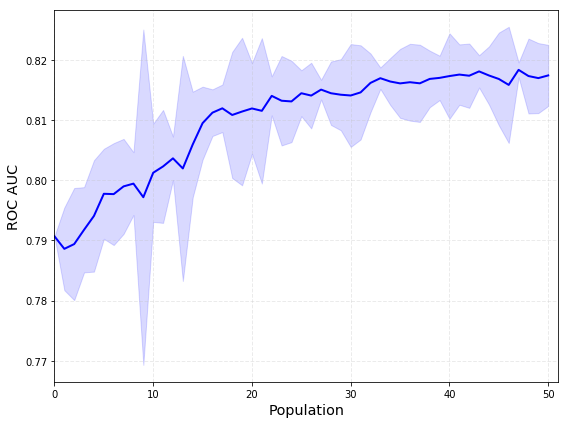

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(log)), [d['avg'] for d in log], color='blue', lw=2)
y_max = np.array([d['avg'] + d['std'] for d in log])
y_min = np.array([d['avg'] - d['std'] for d in log])
plt.fill_between(range(len(log)), y_min, y_max, color='blue', alpha=0.15)
plt.xlim([0.0, len(log)])
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)
plt.ylabel('ROC AUC', fontsize='x-large')
plt.xlabel('Population', fontsize='x-large')
plt.tight_layout()

### AI TI-RADS points assigned to features

In [10]:
hof = np.array(hof).flatten()
hof = hof.tolist()
w = np.array(hof[:1] + [0] + hof[1:3] + [0] + hof[3:])
# Normalize points within each category
w[0:5] = w[0:5] - np.min(w[0:5]) # composition
w[5:10] = w[5:10] - np.min(w[5:10]) # echogenicity
w[10:12] = w[10:12] - np.min(w[10:12]) # shape
w[12:16] = w[12:16] - np.min(w[12:16]) # margin
w[16:] = w[16:] - np.min(w[16:]) # echogenic foci
# Show points
for i in range(len(w)):
    print('{} : {}'.format(df_features.columns[i], w[i]))

Composition_Cannot tell : 0
Composition_Cystic : 0
Composition_Entirely or almost entirely solid : 3
Composition_Mixed cystic_solid : 0
Composition_Spongiform : 0
Echogenicity_Cant classify : 0
Echogenicity_Hyper : 0
Echogenicity_Iso : 0
Echogenicity_Mild Hypo : 2
Echogenicity_Very Hypo : 3
Shape_n : 0
Shape_y : 1
MargA_Cant classify : 0
MargA_Ill-defined : 0
MargA_Lobulated : 2
MargA_Well-defined : 0
Calcs_None : 0
Calcs_Peripheral_eggshell : 2
Calcs_Colloid : 0
Calcs_Macro : 0
Calcs_PEF : 3
